<a href="https://colab.research.google.com/github/bijeon/kaeri_ri/blob/master/ExClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 계측 스펙트럼으로부터의 방사성 핵종 식별 실습

## 환경설정
제일 먼저 위 메뉴의 '런타임'-'런타임 유형 변경'에서 하드웨어 가속기를 'GPU'로 설정해줍니다.  
기본 라이브러리를 불러옵니다. 사용할 라이브러리는 다음과 같습니다.  
tensorflow 2.0 이상 / 용도: 신경망 모델 개발    
numpy 최신 / 용도: data processing    
matplotlib 최신 / 용도: Visualization  
scikit learn 최신 / 용도: 결과 confusion matrix 형태로 표현 및  visualization


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

os.chdir('/content/drive/MyDrive/Colab Notebooks')
import MCML

## 단일 모델들 학습시 활성화
# tf.compat.v1.disable_eager_execution()

## Multi-task 모델 학습시 활성화
# tf.compat.v1.enable_eager_execution()

print('done')

done


In [ ]:
## Colab에서 돌릴 때 Executing op 로 시작하는 메세지가 너무 많이 떠서 이를 없애는 명령을 정의했습니다. 
## Colab에서 돌리는 경우가 아니라면(model을 학습시킬 때 Executing op 로 시작하는 메세지 들이 안뜬다면),
## 아래의 셀 스크립트는 실행하지 않으셔도 됩니다.
import sys, re, logging

class Filter(object):
    def __init__(self, stream):
        self.stream = stream

    def __getattr__(self, attr_name):
        return getattr(self.stream, attr_name)

    def write(self, data):
        if not data.startswith("Executing op"):
            self.stream.write(data)
            self.stream.flush()

    def flush(self):
        self.stream.flush()
  
sys.stdout = Filter(sys.stdout)
sys.stderr = Filter(sys.stderr)

logger = logging.getLogger(__name__)

로드한 라이브러리의 버전과 활용 가능한 자원 "GPU"가 있는지 확인합니다.  
'device_type: "GPU" ' 라는 항목이 프린트 되어야 GPU를 활용할 수 있습니다.

In [ ]:
print('tensorflow version: %s'%tf.__version__)
print('numpy version: %s'%np.__version__)
print('matplotlib version: %s'%mpl.__version__)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()



tensorflow version: 2.5.0
numpy version: 1.19.5
matplotlib version: 3.2.2


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13850720008873372744, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11344216064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3448564340390959386
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

GPU 메모리 설정을 해줍니다.  
본 메모리 설정은 현재 작업에 필요한 최소한의 메모리 만큼을 GPU에 할당하고, 나중에 더 필요할 경우, 더 필요한 만큼만 할당량을 늘리도록 하는 것입니다.  
Tensorflow에서는 이러한 메모리 설정을 따로 해주지 않으면 해당 작업을 GPU 메모리 전부에 할당해 버립니다. 본 실습에서는 그다지 중요하지 않은 부분이지만, 나중에 실제 모델 개발을 하실 때에 GPU 리소스가 충분하지 않으실 경우 꼭 필요한 설정입니다.  
예를들어 GPU 1기의 메모리가 16GB라고 할 때, 한 세션을 돌리는데 필요한 메모리는 8GB라고 하면 동일한 세션 두 개를 한번에 돌릴 수 있는데, GPU 메모리 설정을 해주지 않으면 세션을 한 개 밖에 돌릴 수 없게 됩니다.

In [ ]:
tf.debugging.set_log_device_placement(True)
list_gpu = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in list_gpu:
  tf.config.experimental.set_memory_growth(gpu, True)
  
print('done')

done


## 데이터 로드
본 실습에서 구현할 모델은 Multi-class classification과 Multi-label classification 모델입니다.  
Multi-class 와 Multi-label classification 에 대한 차이는 다음 링크를 참고하여 주세요. (https://wikidocs.net/84581)  
아래에서는 데이터를 불러옵니다.   
총 3개의 선원을 플라스틱 섬광체 검출기로 계측한 스펙트럼들이 csv파일로 저장되어 있습니다.    
데이터의 가장 첫 번째 열은 class를 나타내며, 나머지 500개 열은 500 채널의 계측 스펙트럼을 나타냅니다.  
Class는 1부터 8까지 있으며, 각 class는 해당 스펙트럼이 다음 핵종에 대한 계측 결과임을 의미합니다.  
1: BKG / 2: Na22 / 3: Co60 / 4: Cs137 / 5: Na22 & Co60 / 6: Na22 & Cs137 / 7: Co60 & Cs137 / 8: Na22 & Co60 & Cs137  
각 Class 마다 500개씩 총 4000개의 데이터셋이 있으며, 이를 학습 데이터로 활용할 예정입니다.  
4000개의 데이터셋 중 3000개는 학습, 1000개는 검증용으로 쓸 것입니다.  
현재 데이터는 1~8 클래스가 순서대로 배열되어 있으므로, 이를 랜덤하게 섞어준 뒤 학습, 검증 셋으로 분리 할 것 입니다.
테스트셋은 각 Class마다 100개씩 총 800개의 데이터셋이 있습니다.


In [ ]:
# train_data = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/TRAINSET_500.csv',delimiter = ',')
print(train_data.shape)
# test_data = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/TESTSET.csv',delimiter = ',')
print(test_data.shape)

print(train_data)
## Train data shuffle
np.random.seed(111)
s = np.arange(len(train_data))
np.random.shuffle(s)
train_data = train_data[s,:]
print(train_data)
s = np.arange(len(test_data))
np.random.shuffle(s)
test_data = test_data[s,:]

(4000, 501)
(800, 501)
[[  1.  65.  40. ...   0.   0.   0.]
 [  1.  10.  12. ...   0.   0.   0.]
 [  1.  29.  21. ...   0.   0.   0.]
 ...
 [  8.  49.  60. ...   0.   0.   0.]
 [  8. 358. 206. ...   0.   0.   0.]
 [  8. 146.  97. ...   0.   0.   0.]]
[[  4.  20.  26. ...   0.   0.   0.]
 [  7. 352. 321. ...   0.   0.   0.]
 [  5.  38.  25. ...   0.   0.   0.]
 ...
 [  1.  14.  13. ...   0.   0.   0.]
 [  4.  30.  33. ...   0.   0.   0.]
 [  8.  48.  52. ...   0.   0.   0.]]


불러온 데이터셋 중 input data만 분리합니다.  
학습데이터셋에서 Train, validation set을 분리합니다. 
그리고 입력 데이터(스펙트럼)를 정규화 합니다.  
정규화에 사용한 방법은, 각 스펙트럼을 각 스펙트럼의 총 카운트 수로 나눈 뒤, 100을 곱해주는 방식입니다. 각 스펙트럼을 각 스펙트럼의 총 카운트 수로 나눔으로써 각 스펙트럼을 확률밀도함수(Probabilistic density function, PDF)처럼 표한할 수 있고, 여기에 100을 곱해줌으로써 PDF의 y축을 백분률로 표현할 수 있습니다.

In [ ]:
train_x = train_data[:3000,1:]/np.sum(train_data[:3000,1:],axis=1).reshape(-1,1)*100
val_x = train_data[3000:,1:]/np.sum(train_data[3000:,1:],axis=1).reshape(-1,1)*100
test_x = test_data[:,1:]/np.sum(test_data[:,1:],axis=1).reshape(-1,1)*100

print(train_x.shape)
print(test_x.shape)
# print(train_data)

(3000, 500)
(800, 500)


In [ ]:
np.sum(train_data[:3000,1:],axis=1)

array([1236., 1654., 1854., ..., 1306., 1120., 1910.])

불러온 데이터셋에서 class만 불러와서 이를 categorical representation (one-hot encoding)로 표현합니다. 
본 실습에서 정의할 category representation은 다음과 같습니다.  
Multi-class classification  
1: BKG [1 0 0 0 0 0 0 0]  
2: Na22 [0 1 0 0 0 0 0 0]  
3: Co60 [0 0 1 0 0 0 0 0]  
나머지도 같은 방식으로....  
Multi-label classification   
[Na22유무(0 or 1), Co60유무(0 or 1), Cs137유무(0 or 1)]  
정확히는, Multi-label binary classification이라는 표현이 맞고, 각 핵종의 유무가 각 label을 의미합니다. 그리고 각 label은 핵종 유무(0 또는 1)를 나타내는 binary class를 갖습니다. 

In [ ]:
# MCML.py 에 아래와 같이 정의되어 있음.
# def multilabel_to_categorical(data,num_classes):
#   j=0
#   cat = np.zeros([len(data),num_classes])
#   for d in data:
#     if int(d)==1: cat[j,:] = [0,0,0]
#     elif int(d)==2: cat[j,:]=[1,0,0]
#     elif int(d)==3: cat[j,:]=[0,1,0]
#     elif int(d)==4: cat[j,:]=[0,0,1]
#     elif int(d)==5: cat[j,:]=[1,1,0]
#     elif int(d)==6: cat[j,:]=[1,0,1]
#     elif int(d)==7: cat[j,:]=[0,1,1]
#     elif int(d)==8: cat[j,:]=[1,1,1]
#     j = j+1
#   return cat

# # Multi-label classification category one-hot representation
train_y_ml = MCML.multilabel_to_categorical(train_data[:3000,0],num_classes=3)
val_y_ml = MCML.multilabel_to_categorical(train_data[3000:,0],num_classes=3)
test_y_ml = MCML.multilabel_to_categorical(test_data[:,0],num_classes=3)

# # Multi-class classification category one-hot representation
train_y_mc = tf.keras.utils.to_categorical(train_data[:3000,0]-1, num_classes=8)
val_y_mc = tf.keras.utils.to_categorical(train_data[3000:,0]-1, num_classes=8)
test_y_mc = tf.keras.utils.to_categorical(test_data[:,0]-1, num_classes=8)

# print(train_y_ml.shape)
# print(train_y_mc.shape)

In [ ]:
print(test_y_ml[690,:])
print(test_data[690,0])

[0. 0. 1.]
4.0


불러온 학습셋의 각 핵종 별 스펙트럼들을 확인해봅시다.


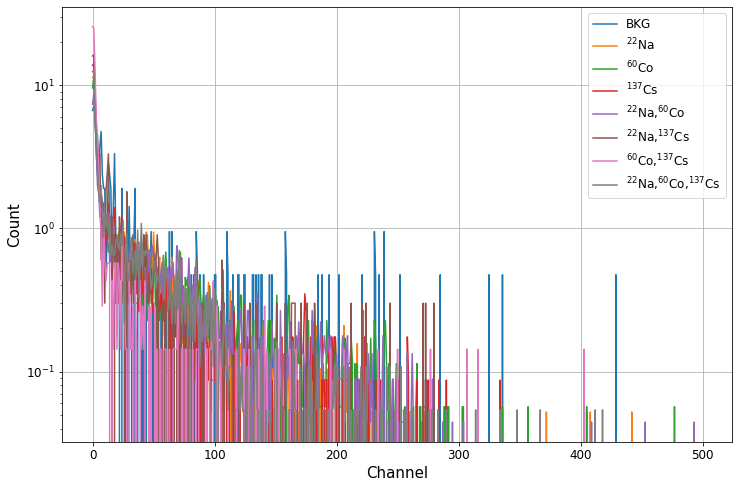

In [ ]:
Source = ['BKG','$^{22}$Na','$^{60}$Co','$^{137}$Cs','$^{22}$Na,$^{60}$Co','$^{22}$Na,$^{137}$Cs','$^{60}$Co,$^{137}$Cs','$^{22}$Na,$^{60}$Co,$^{137}$Cs']
plt.figure(figsize=[12,8])
for i in range(8):
  plt.semilogy(test_x[100*i,:],label=Source[i])
plt.legend(loc='best',fontsize='12')
plt.grid()
plt.xlabel('Channel',fontsize='15')
plt.ylabel('Count',fontsize='15')
plt.tick_params(axis='both',labelsize='12')

## 모델 정의
Multi-class classifier 와 Multi-label binary classifier를 정의합니다.  
모델 구조는 동일하게 임의로 설정하겠습니다.  
각 모델은 300개의 인공뉴런을 갖는 2개의 은닉층과 1개의 출력층으로 정의하였고, Dropout을 정의하였습니다.  
정의할 떄의 차이점은, Multi-class 모델의 경우 맨 마지막 레이어의 활성화 함수를 일반적인 classification문제에서 많이 쓰는 'softmax'로 정의하는데, Multi-label 모델은 그냥 'sigmoid'를 쓴 다는 것 입니다.  
softmax함수의 경우 출력 값을 0\~1사이로 정규화 하여 출력의 총 합이 1이 되도록 만드는 함수로 one-hot representation에서 1이 하나 밖에 없는 multi-class 문제에는 적합하나, 1이 여러개 있는 Multi-label 문제에서는 활용할 수 없습니다. 따라서 이 경우에는 출력 값을 0\~1사이로 내는 sigmoid를 사용합니다.  


In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

def mc_classifier(l_input,l_output,droprate):
  input_data = layers.Input(shape=(l_input,))
  L1 = layers.Dense(50,activation='ReLU')(input_data)
  L1 = layers.Dropout(droprate)(L1)
  L1 = layers.BatchNormalization()(L1)
  L2 = layers.Dense(50,activation='ReLU')(L1)
  L2 = layers.Dropout(droprate)(L2)
  L2 = layers.BatchNormalization()(L2)
  L3 = layers.Dense(l_output,activation='softmax')(L2)
  return Model(input_data,L3)

def ml_classifier(l_input,l_output,droprate):
  input_data = layers.Input(shape=(l_input,))
  L1 = layers.Dense(50,activation='ReLU')(input_data)
  L1 = layers.Dropout(droprate)(L1)
  L1 = layers.BatchNormalization()(L1)
  L2 = layers.Dense(50,activation='ReLU')(L1)
  L2 = layers.Dropout(droprate)(L2)
  L2 = layers.BatchNormalization()(L2)
  L3 = layers.Dense(l_output,activation='sigmoid')(L2)
  return Model(input_data,L3)

MC_classifier = mc_classifier(l_input=500,l_output=8,droprate=0.2)
ML_classifier = ml_classifier(l_input=500,l_output=3,droprate=0.2)

MC_classifier.summary()
ML_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense (Dense)                (None, 50)                25050     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200   

각 모델을 훈련시킬 옵티마이저를 정의하고 모델을 컴파일 하겠습니다.  
옵티마이저는 여기저기 많이 쓰이는 Adam optimzier를 사용하겠습니다.  
컴파일 할 때 두 모델의 차이점은, 다른 손실함수를 정의해줘야 한다는 것입니다.  
Multi-class 에서는 categorical crossentropy를, Multi-label 에서는 binary_crossentropy를 손실함수로 정의할 것입니다.  

In [ ]:
from tensorflow.keras.optimizers import Adam

mc_opt = Adam(learning_rate=0.0001)
ml_opt = Adam(learning_rate=0.0001)

MC_classifier.compile(optimizer = mc_opt,loss='categorical_crossentropy',metrics=['accuracy'])
ML_classifier.compile(optimizer = ml_opt,loss='binary_crossentropy',metrics=['binary_accuracy'])

# print(ML_classifier.metrics_names)

## 모델 학습 및 결과 확인
이제 모델을 학습시켜야 합니다. 그 전에 모델 학습시 많이 일어나는 'overfitting'을 방지하기 위하여 몇 가지 설정을 해줘야 합니다. 가장 먼저 validation dataset을 정의해줘야 하는데요, 일반적으로 데이터셋을 불러와서 일부를 떼어내기도 하고, 학습과정에서 정해진 비율만큼 임의로 나누도록 설정할 수도 있습니다. 본 실습에서는 학습데이터의 수가 그리 많지 않으므로 정해진 비율만큼 임의로 나누도록 설정하겠습니다. 이렇게 validation set을 설정해주면, 모델 학습간에 loss를 train loss와 validation loss 두 가지를 볼 수 있습니다. train set은 학습 간에 활용되는 데이터셋이고, validation set은 학습에 활용되지 않으며, 모델이 overfitting되는지 확인하기 위해 활용하는 데이터셋입니다. 학습 epoch가 계속 진행될 수록 train loss는 계속 감소하는 추세를 보이나 validation loss는 그렇지 않습니다. 따라서 train loss는 감소하지만 validation loss는 더이상 감소하지 않으면, 모델이 train set에 overfitting 되고 있는 것이라고 판단할 수 있습니다.   
두 번째는 callback함수를 정의해주는 것 입니다. 많이 쓰는 옵션은 Earlystopping 과 ModelCheckpoint 입니다. 두 옵션은 학습과정에서 validation loss를 모니터링 하는 것은 동일 하나 Earlystopping은 손실 값이 증가하는 경향을 보일 때 이를 중지시키는 방식이고, ModelCheckpoint는 중지 없이 정의한 에포크 만큼 학습을 계속 시키고 전체 에포크에서 가장 작은 손실 값을 보였던 에포크의 모델을 중간저장하여 나중에 활용할 수 있도록 해주는 방식입니다. 본 실습에서는 EarlyStopping을 사용하겠습니다.


In [ ]:
ES_MC = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20,restore_best_weights=True)

history_MC=MC_classifier.fit(x=train_x,y=train_y_mc,validation_data=(val_x,val_y_mc),batch_size=2**8,epochs=100,validation_split=0.2,callbacks=[ES_MC],shuffle=True)

Epoch 1/100
10/10 [==============================] - 4s 47ms/step - loss: 2.8256 - accuracy: 0.1029 - val_loss: 2.0911 - val_accuracy: 0.1500
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 2.7158 - accuracy: 0.1154 - val_loss: 2.0767 - val_accuracy: 0.1533
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 2.6237 - accuracy: 0.1350 - val_loss: 2.0622 - val_accuracy: 0.1567
Epoch 4/100
10/10 [==============================] - 0s 15ms/step - loss: 2.5367 - accuracy: 0.1604 - val_loss: 2.0470 - val_accuracy: 0.1683
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 2.4815 - accuracy: 0.1658 - val_loss: 2.0304 - val_accuracy: 0.1750
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 2.4130 - accuracy: 0.1779 - val_loss: 2.0135 - val_accuracy: 0.1883
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 2.3190 - accuracy: 0.2104 - val_loss: 1.9956 - val_accuracy: 0.2200
Epoch 

학습이 끝났으니 Multi-class classification 모델의 성능을 확인해 보겠습니다.  
결과는 혼돈행렬(Confusion matrix). 형태로 표현할 것입니다.

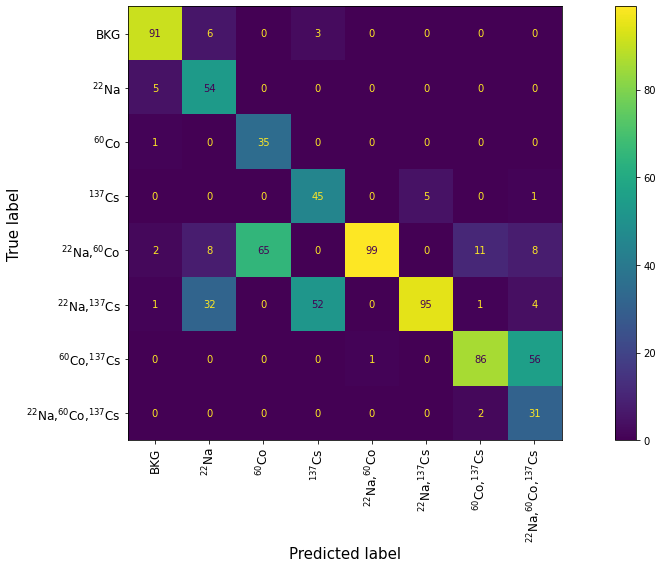

Accuracy: 67.0 %


In [ ]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay

pred_y_mc = MC_classifier(test_x)
y_pred_mc = tf.argmax(pred_y_mc,axis=1)
y_true_mc = tf.argmax(test_y_mc,axis=1)

MCCM = confusion_matrix(y_pred_mc,y_true_mc)
fig, ax = plt.subplots(figsize=[15,8])
disp = ConfusionMatrixDisplay(confusion_matrix = MCCM, display_labels=Source)
disp.plot(xticks_rotation='vertical',values_format='d',ax=ax)
plt.tick_params(axis='both',labelsize='12')
plt.xlabel('Predicted label',fontsize='15')
plt.ylabel('True label',fontsize='15')
fig.tight_layout()
plt.show()
print('Accuracy: %s %%' %((MCCM[0,0]+MCCM[1,1]+MCCM[2,2]+MCCM[3,3]+MCCM[4,4]+MCCM[5,5]+MCCM[6,6]+MCCM[7,7])/sum(sum(MCCM))*100))


In [ ]:
ES_ML = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',patience=100,restore_best_weights=True)

history_ML = ML_classifier.fit(x=train_x,y=train_y_ml,validation_data=(val_x,val_y_ml),batch_size=2**8,epochs=100,validation_split=0.2,callbacks=[ES_ML])

Epoch 1/100
10/10 [==============================] - 1s 39ms/step - loss: 0.8852 - binary_accuracy: 0.4940 - val_loss: 0.7277 - val_binary_accuracy: 0.4972
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8321 - binary_accuracy: 0.5339 - val_loss: 0.7163 - val_binary_accuracy: 0.4983
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7916 - binary_accuracy: 0.5483 - val_loss: 0.7061 - val_binary_accuracy: 0.5044
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7572 - binary_accuracy: 0.5760 - val_loss: 0.6968 - val_binary_accuracy: 0.5061
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7192 - binary_accuracy: 0.5961 - val_loss: 0.6873 - val_binary_accuracy: 0.5117
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7050 - binary_accuracy: 0.6049 - val_loss: 0.6771 - val_binary_accuracy: 0.5328
Epoch 7/100
10/10 [==============================] - 0s 13ms/ste

학습이 끝났으니 Multi-label classification 모델의 성능을 확인해보겠습니다.    
결과는 마찬가지로 혼돈행렬(confusion matrix)로 볼 것입니다.  
본 모델은 각 label 을 binary classification 하도록 설계되어, 혼돈 행렬이 각 label 마다 있습니다.  
각 label의 혼돈행렬은 다음과 같은 결과를 나타냅니다.  
[ True Negative(TN)  False Negative (FN) ]   
[ False Positive(FP) True Positive (TP)  ]  
TN: false를 false로 call  
FN: true를 false로 call  
FP: false를 true로 call    
TP: true를 true로 call  




In [ ]:
pred_y_ml = ML_classifier(test_x)
y_pred_ml = np.round(pred_y_ml)

MLCM = multilabel_confusion_matrix(test_y_ml,y_pred_ml)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
disp0 = ConfusionMatrixDisplay(confusion_matrix = MLCM[0], display_labels=['True','False'])
disp0.plot(xticks_rotation='vertical',values_format='d',ax=ax1)
ax1.set_title('Na22',fontsize=20)
ax1.tick_params(axis='both',labelsize='18')
disp1 = ConfusionMatrixDisplay(confusion_matrix = MLCM[1], display_labels=['True','False'])
disp1.plot(xticks_rotation='vertical',values_format='d',ax=ax2)
ax2.set_title('Co60',fontsize=20)
ax2.tick_params(axis='both',labelsize='18')
disp2 = ConfusionMatrixDisplay(confusion_matrix = MLCM[2], display_labels=['True','False'])
disp2.plot(xticks_rotation='vertical',values_format='d',ax=ax3)
ax3.set_title('Cs137',fontsize=20)
ax3.tick_params(axis='both',labelsize='18')
fig.tight_layout()
plt.show()


acc_label1 = (MLCM[0][0][0]+MLCM[0][1][1])/sum(sum(MLCM[0])) * 100
acc_label2 = (MLCM[1][0][0]+MLCM[1][1][1])/sum(sum(MLCM[1])) * 100
acc_label3 = (MLCM[2][0][0]+MLCM[2][1][1])/sum(sum(MLCM[2])) * 100
print('Accuracy for Na22: %s %%, for Co60: %s %% , for Cs137: %s %%, for total: %s %%'%(acc_label1,acc_label2,acc_label3,(acc_label1+acc_label2+acc_label3)/3))



NameError: ignored

## Keras tuner를 이용한 하이퍼 파라미터 탐색
모델의 하이퍼파라미터를 탐색하는 과정을 소개합니다.  
본 실습에서는 keras-tuner를 이용하여 하이퍼파라미터를 튜닝 할 것입니다.  
아래 셀의 코드를 실행하여 colab 환경에서 keras tuner를 설치하고 불러 옵니다.

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

튜너를 불러왔다면, 이제 튜닝을 위한 모델 함수를 정의합니다.  
(시간관계상 Multi-class classification 모델에 대한 파라미터 튜닝만을 다루겠습니다.)  
hp는 하이퍼파라미터 튜닝을 위한 변수들입니다. 변수의 범위는 아래와 같이 지정 가능합니다  
ex) hp.Range('units', min_value=16, max_value=512, step=16) (특정 범위의 정수)  
모델 정의에서 반환해야할 것은 컴파일까지 완료된 모델입니다.


In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()
  ## 은닉층의 개수는 2~5까지)
  for i in range(hp.Int('num_layers',min_value=2,max_value=5,step=1)):
    model.add(tf.keras.layers.Dense(units = hp.Int('Neurons_@%s_layer'%(i+1),
                                    min_value=16,max_value=512,step=16),
                                    activation='relu'))
  model.add(tf.keras.layers.Dense(8,activation='softmax'))

  model.compile(
      optimizer = tf.keras.optimizers.Adam(1e-3),
      loss = 'categorical_crossentropy',
      metrics=['accuracy'])
  return model
  

모델을 정의했으니, 튜너를 정의하고 수행하면 됩니다.  
keras tuner에서는 RandomSearch, BayesianOptimization, Hyperband 이렇게 세가지 방법으로 튜닝을 할 수 있습니다,  
본 실습에서는 Bayesian optimization을 활용합니다.  

In [ ]:
from kerastuner.tuners import Hyperband
## 최대 탐색 횟수, 탬색에서 빌드할 모델의 갯수에 따라 결과가 달라질 수 있습니다.
HyperTuner = Hyperband(
    model_builder, ## 모델 함수
    objective = 'val_accuracy', ## 최소화 하고자 하는 목적함수
    max_epochs = 50, ## 최대 탐색 횟수
    factor=3, ## 한번의 탐색에서 빌드하고 학습할 모델의 개수. 2이상으로 설정하면 한번의 탐색에서 같은 파라미터로 모델을 여러개 돌려봄.
    overwrite=True,
    directory="./",
    project_name='MC_classifier_tuning')

## epochs 설정에 따라 결과가 달라질 수 있습니다.
HyperTuner.search(x=train_x,y=train_y_mc, 
                     epochs=100,
                     validation_data=(val_x,val_y_mc))



In [ ]:
## 튜닝 결과 보기. 성능이 높은 순서로 내림차순.
HyperTuner.results_summary ()

탐색이 끝났으면 최적의 하이퍼파라미터로 모델을 빌드, 훈련시킵니다.



In [ ]:
best_parameters = HyperTuner.get_best_hyperparameters(num_trials=1)[0]
MC_classifier_tuned = HyperTuner.hypermodel.build(best_parameters)

ES_MC = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=100,restore_best_weights=True)
history_MC_tuned=MC_classifier_tuned.fit(x=train_x,y=train_y_mc,batch_size=2**8,epochs=100,validation_split=0.2,shuffle=True,callbacks=[ES_MC])
MC_classifier_tuned.summary()

튜닝된 모델의 결과를 확인합니다.

In [ ]:
# from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay

pred_y_mc_t = MC_classifier_tuned(test_x)
y_pred_mc_t = tf.argmax(pred_y_mc_t,axis=1)
y_true_mc = tf.argmax(test_y_mc,axis=1)

MCCM_t = confusion_matrix(y_pred_mc_t,y_true_mc)
fig, ax = plt.subplots(figsize=[15,8])
disp = ConfusionMatrixDisplay(confusion_matrix = MCCM_t, display_labels=Source)
disp.plot(xticks_rotation='vertical',values_format='d',ax=ax)
plt.tick_params(axis='both',labelsize='12')
plt.xlabel('Predicted label',fontsize='15')
plt.ylabel('True label',fontsize='15')
fig.tight_layout()
plt.show()
print('Accuracy: %s %%' %((MCCM_t[0,0]+MCCM_t[1,1]+MCCM_t[2,2]+MCCM_t[3,3]+MCCM_t[4,4]+MCCM_t[5,5]+MCCM_t[6,6]+MCCM_t[7,7])/sum(sum(MCCM_t))*100))